In [1]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install transformers -U
!pip uninstall transformers accelerate
!pip install transformers accelerate
!pip install torch -U
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-

In [2]:
from accelerate import Accelerator
accelerator = Accelerator()
print("Accelerate device:", accelerator.device)

Accelerate device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/buggy/bugs'
with open(file_path, 'r') as file:
    sample_content = file.read(1000)

sample_content


'[\n  {\n    "fixCommitSHA1": "e1b4341bcf2075abbb30b3336aa889a04f683cd4",\n    "fixCommitParentSHA1": "e15dbdf6aceac531383d22369d7f09b40106f06e",\n    "bugFilePath": "modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java",\n    "fixPatch": "diff --git a/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java b/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java\\nindex e288bae..a5fa9b4 100644\\n--- a/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java\\n+++ b/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java\\n@@ -38,7 +38,7 @@\\n         }\\n \\n         try {\\n-            runtimeService.startProcessInstanceByKey(\\"shellCommandStart\\");\\n+            runtimeService.startProcessIn

#First dataset_BART Model

In [34]:
import torch
import gc


if torch.cuda.is_available():
    torch.cuda.empty_cache()


gc.collect()

torch.cuda.reset_peak_memory_stats()

print("GPU memory cleared")

GPU memory cleared


In [7]:
import time
import json
import pandas as pd
import numpy as np
import difflib
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return description, patch

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")
        else:
            print(line)

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=1e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        # Generate and print patches for these examples
        for i, description in enumerate(example_descriptions):
            original, patch = generate_patch(description, model, tokenizer, device)
            print(f"Example {i+1}:")
            print("Buggy Code (Red):")
            print(f"\033[91m{original}\033[0m")
            print("Generated Patch (Green and Red):")
            display_comparisons(original, patch)
            print("\n")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Example of buggy code: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", response = Void.class, authorizations = {
Example of fixed code: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", authorizations = {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.673200,1.820395
2,1.613900,1.743051
3,1.587900,1.712857


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Results Statistics:
eval_loss: 1.7128570079803467
eval_runtime: 6.4086
eval_samples_per_second: 107.043
eval_steps_per_second: 13.419
epoch: 3.0
Execution Time: 1273.17 seconds
Example 1:
Buggy Code (Red):
assertEquals("line 1:19 reportAmbiguity d=1: ambigAlts={1..2}:[(25,1,[]), (25,2,[],up=1)],conflictingAlts={1..2},dipsIntoOuterContext, input='else'\n",
Generated Patch (Green and Red):
- assertEquals("line 1:19 reportAmbiguity d=1: ambigAlts={1..2}:[(25,1,[]), (25,2,[],up=1)],conflictingAlts={1..2},dipsIntoOuterContext, input='else'\n",


Example 2:
Buggy Code (Red):
Mockito.mock( AcceptorInstanceStore.class), Mockito.mock( Timeouts.class) );
Generated Patch (Green and Red):
- Mockito.mock( AcceptorInstanceStore.class), Mockito.mock( Timeouts.class) );


Example 3:
Buggy Code (Red):
CacheBuilder<Object, Object> builder = new CacheBuilder<>();
Generated Patch (Green and Red):
- CacheBuilder<Object, Object> builder = new CacheBuilder<>();




In [8]:
import time
import json
import pandas as pd
import numpy as np
import difflib
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    patch = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return description, patch

def display_comparisons(original, modified):
    diff = difflib.ndiff(original.splitlines(), modified.splitlines())
    for line in diff:
        if line.startswith('-'):
            print(f"\033[91m{line}\033[0m")
        elif line.startswith('+'):
            print(f"\033[92m{line}\033[0m")
        else:
            print(line)

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()
    patch_count = 0

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=1e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        # Generate and print patches for these examples
        for i, description in enumerate(example_descriptions):
            original, patch = generate_patch(description, model, tokenizer, device)
            patch_count += 1
            print(f"Example {i+1}:")
            print("Buggy Code (Red):")
            print(f"\033[91m{original}\033[0m")
            print("Generated Patch (Green and Red):")
            display_comparisons(original, patch)
            print("\n")

    print(f"Total patches generated: {patch_count}")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Example of buggy code: -- a/src/main/java/com/puppycrawl/tools/checkstyle/checks/imports/CustomImportOrderCheck.java
Example of fixed code: ++ b/src/main/java/com/puppycrawl/tools/checkstyle/checks/imports/CustomImportOrderCheck.java



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.692200,1.595719
2,1.630600,1.597036
3,1.606400,1.566002


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Results Statistics:
eval_loss: 1.5660017728805542
eval_runtime: 6.3999
eval_samples_per_second: 107.189
eval_steps_per_second: 13.438
epoch: 3.0
Execution Time: 1277.94 seconds
Example 1:
Buggy Code (Red):
verify(checkConfig, getPath("InputEmptyBlockDefault.java"), expected);
Generated Patch (Green and Red):
- verify(checkConfig, getPath("InputEmptyBlockDefault.java"), expected);


Example 2:
Buggy Code (Red):
@UriParam(defaultValue = "false")
Generated Patch (Green and Red):
- @UriParam(defaultValue = "false")


Example 3:
Buggy Code (Red):
public static PotionEffectType WATER_BREATHING = new PotionEffectTypeWrapper(13);
Generated Patch (Green and Red):
- public static PotionEffectType WATER_BREATHING = new PotionEffectTypeWrapper(13);


Total patches generated: 3


Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Example of buggy code: -- a/src/main/java/com/puppycrawl/tools/checkstyle/checks/imports/CustomImportOrderCheck.java
Example of fixed code: ++ b/src/main/java/com/puppycrawl/tools/checkstyle/checks/imports/CustomImportOrderCheck.java



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.692200,1.595719
2,1.630600,1.597036
3,1.606400,1.566002


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Results Statistics:
eval_loss: 1.5660017728805542
eval_runtime: 6.3994
eval_samples_per_second: 107.198
eval_steps_per_second: 13.439
epoch: 3.0
Execution Time: 1269.56 seconds


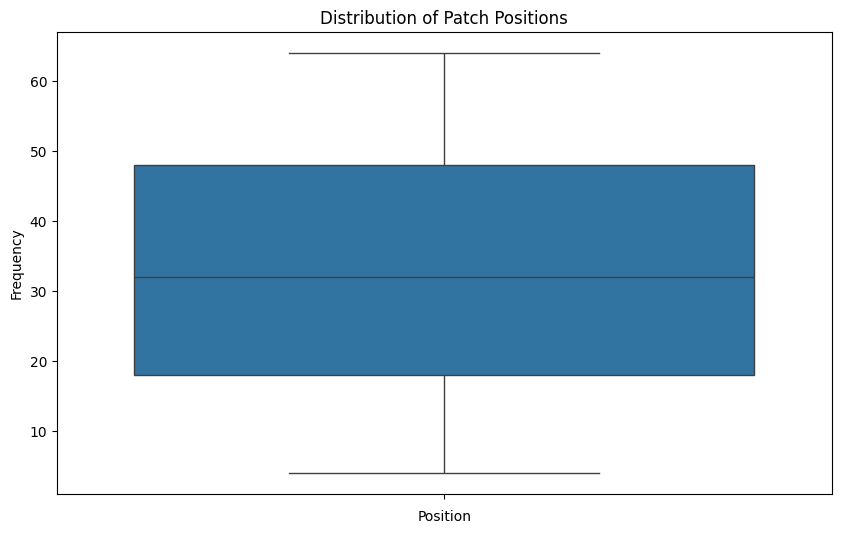

Example 1:
Buggy Code: verify(checkConfig, getPath("InputEmptyBlockDefault.java"), expected);
Generated Patch: ('verify(checkConfig, getPath("InputEmptyBlockDefault.java"), expected);', '')

Example 2:
Buggy Code: @UriParam(defaultValue = "false")
Generated Patch: ('@UriParam(defaultValue = "false")', '')

Example 3:
Buggy Code: public static PotionEffectType WATER_BREATHING = new PotionEffectTypeWrapper(13);
Generated Patch: ('public static PotionEffectType WATER_BREATHING = new PotionEffectTypeWrapper(13);', '')



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def simulate_patch_position(description, patch):
    """
    Simulate a score for where the patch is applied. For illustration,
    let's assume this function returns a random position based on the length of the description.
    """
    return np.random.randint(0, len(description))

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=1e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions = generate_patches_and_positions(example_descriptions, model, tokenizer, device)
        plot_positions(positions)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()



Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Example of buggy code: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", response = Void.class, authorizations = {
Example of fixed code: @ApiOperation(value = "Updates a pet in the store with form data", nickname = "updatePetWithForm", notes = "", authorizations = {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.673200,1.820395
2,1.613900,1.743051
3,1.587900,1.712857


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Results Statistics:
eval_loss: 1.7128570079803467
eval_runtime: 6.3934
eval_samples_per_second: 107.299
eval_steps_per_second: 13.451
epoch: 3.0
Execution Time: 1276.61 seconds


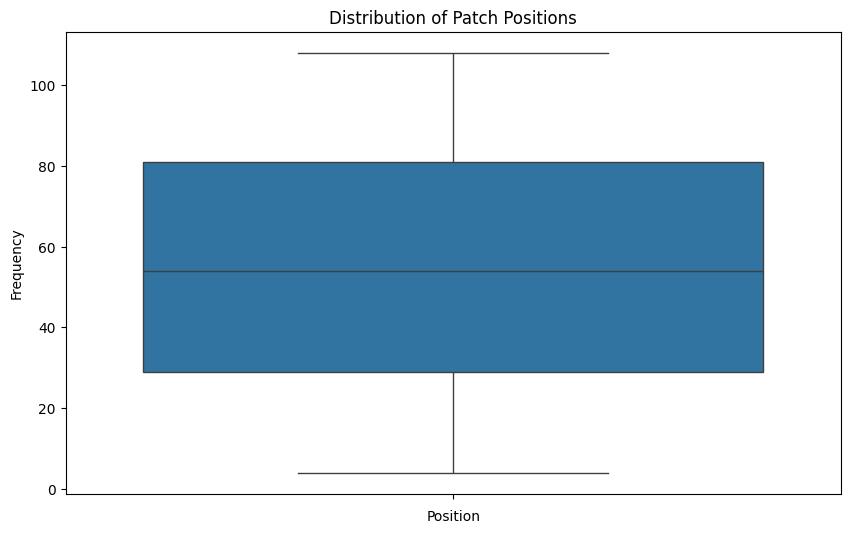

Max time: 0.1537s, Min time: 0.1414s, Average time: 0.1481s
Example 1:
Buggy Code: assertEquals("line 1:19 reportAmbiguity d=1: ambigAlts={1..2}:[(25,1,[]), (25,2,[],up=1)],conflictingAlts={1..2},dipsIntoOuterContext, input='else'\n",
Generated Patch: 

Example 2:
Buggy Code: Mockito.mock( AcceptorInstanceStore.class), Mockito.mock( Timeouts.class) );
Generated Patch: 

Example 3:
Buggy Code: CacheBuilder<Object, Object> builder = new CacheBuilder<>();
Generated Patch: 



In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric

def simulate_patch_position(description, patch):
    return np.random.randint(0, len(description))

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device, time_budget):
    positions = []
    patches = []
    timing_data = []
    start_time = time.time()

    for description in descriptions:
        if time.time() - start_time > time_budget:
            print("Time budget exceeded, stopping patch generation.")
            break

        patch_start_time = time.time()
        patch = generate_patch(description, model, tokenizer, device)
        patch_end_time = time.time()

        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
        timing_data.append(patch_end_time - patch_start_time)

    return patches, positions, timing_data

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def summarize_timing_data(timing_data):
    max_time = max(timing_data)
    min_time = min(timing_data)
    avg_time = np.mean(timing_data)
    print(f"Max time: {max_time:.4f}s, Min time: {min_time:.4f}s, Average time: {avg_time:.4f}s")

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })

        display_dataset_statistics(dataset)

        tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
        model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=1e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        time_budget = 60
        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions, timing_data = generate_patches_and_positions(example_descriptions, model, tokenizer, device, time_budget)
        plot_positions(positions)
        summarize_timing_data(timing_data)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()



#Firstdatset_T5

In [12]:
import time
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]
import time
import json
import pandas as pd
import numpy as np
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")


def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })

        display_dataset_statistics(dataset)

        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=1e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        for i, description in enumerate(example_descriptions):
            patch = generate_patch(description, model, tokenizer, device)
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Example of buggy code: @isPositiveNumber
Example of fixed code: @isPositiveNumber(includeZero = true)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.000000,nan
2,21.550600,nan
3,0.000000,nan


Results Statistics:
eval_loss: nan
eval_runtime: 14.0989
eval_samples_per_second: 48.656
eval_steps_per_second: 6.1
epoch: 3.0
Execution Time: 2251.41 seconds
Example 1:
Buggy Code: -- a/src/it/java/com/google/checkstyle/test/base/BaseCheckTestSupport.java
Generated Patch: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --

Example 2:
Buggy Code: static SourceMapSection forURL(String value, int line, int column) {
Generated Patch: static SourceMapSection forURL(String value, int line, int column)  static  static staticURL(String value, int line, int column) static for static static static static static static static static.

Example 3:
Buggy Code: return metaData.getColumnDisplaySize(column);
Generated Patch: re

Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Example of buggy code: -- a/src/main/java/com/puppycrawl/tools/checkstyle/checks/imports/CustomImportOrderCheck.java
Example of fixed code: ++ b/src/main/java/com/puppycrawl/tools/checkstyle/checks/imports/CustomImportOrderCheck.java



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,4595280773.120000,nan
2,0.000000,nan
3,0.377600,nan


Results Statistics:
eval_loss: nan
eval_runtime: 14.1368
eval_samples_per_second: 48.526
eval_steps_per_second: 6.083
epoch: 3.0
Execution Time: 2254.30 seconds


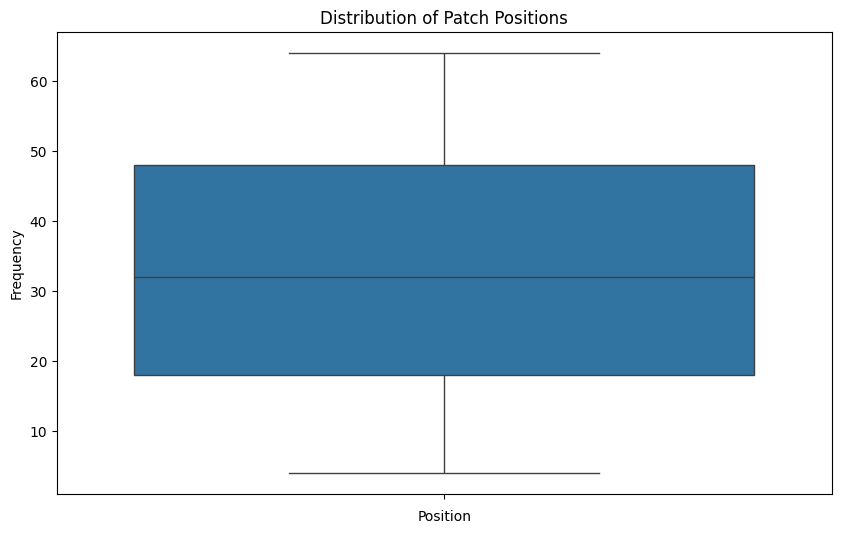

Example 1:
Buggy Code: verify(checkConfig, getPath("InputEmptyBlockDefault.java"), expected);
Generated Patch: lockDefault.java"); if(checkConfig, expected); if(checkConfig, expected); if(checkConfig); if(checkConfig); if(checkConfig); if(checkConfig); if(checkConfig); if(checkConfig); if(checkConfig);

Example 2:
Buggy Code: @UriParam(defaultValue = "false")
Generated Patch: @UriParam(defaultValue = "true")

Example 3:
Buggy Code: public static PotionEffectType WATER_BREATHING = new PotionEffectTypeWrapper(13);
Generated Patch: EffectType WATER_BREATHING = new PotionEffectTypeWrapper(13); public static PotionEffectType WATER_BREATHING = new public static PotionEffectTypeWrapper(13);



In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]
import time
import json
import pandas as pd
import numpy as np
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch

def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")


def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
def simulate_patch_position(description, patch):
    """
    Simulate a score for where the patch is applied. For illustration,
    let's assume this function returns a random position based on the length of the description.
    """
    return np.random.randint(0, len(description))

def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })

        display_dataset_statistics(dataset)

        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=1e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions = generate_patches_and_positions(example_descriptions, model, tokenizer, device)
        plot_positions(positions)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Example of buggy code: private final PassFactory collapseVariableDeclarations =
Example of fixed code: final PassFactory collapseVariableDeclarations =



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,329107.420000,nan
2,0.728500,nan
3,222596.040000,nan


Results Statistics:
eval_loss: nan
eval_runtime: 14.1211
eval_samples_per_second: 48.58
eval_steps_per_second: 6.09
epoch: 3.0
Execution Time: 2248.76 seconds


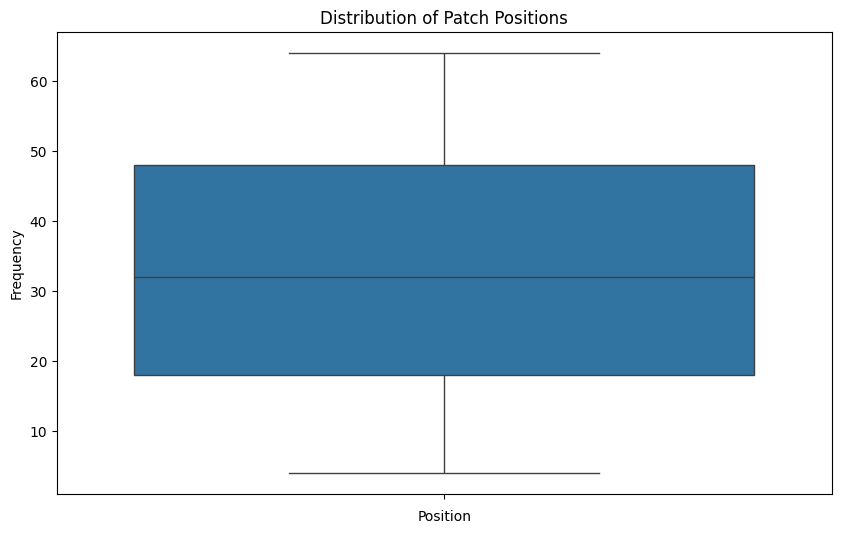

Max time: 4.9426s, Min time: 0.2933s, Average time: 3.2771s
Example 1:
Buggy Code: this(uriBuilder, that.config.snapshot());
Generated Patch: this(uriBuilder, that.config.snapshot()); this(uriBuilder, that.config.snapshot()); this(uriBuilder, that.config.snapshot()); this(uriBuilder, that.config.snapshot()); this(uriBuilder, that.config.snapshot()); this(uriBuilder, that.config.snapshot());

Example 2:
Buggy Code: -- a/core/server/common/src/main/java/alluxio/master/journal/ufs/UfsJournalLogWriter.java
Generated Patch: -- a/core/server/common/src/main/java/alluxio/ -- a/core/server/common/src/main/java/alluxio/journal/ -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --/core/////////////////

Example 3:
Buggy Code: "error(50): <string>:1:0: 'A' came as a complete surprise to me\n",
Generated Patch: not_duplicate



In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric

def simulate_patch_position(description, patch):
    return np.random.randint(0, len(description))

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device, time_budget):
    positions = []
    patches = []
    timing_data = []
    start_time = time.time()

    for description in descriptions:
        if time.time() - start_time > time_budget:
            print("Time budget exceeded, stopping patch generation.")
            break

        patch_start_time = time.time()
        patch = generate_patch(description, model, tokenizer, device)
        patch_end_time = time.time()

        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
        timing_data.append(patch_end_time - patch_start_time)

    return patches, positions, timing_data

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def summarize_timing_data(timing_data):
    max_time = max(timing_data)
    min_time = min(timing_data)
    avg_time = np.mean(timing_data)
    print(f"Max time: {max_time:.4f}s, Min time: {min_time:.4f}s, Average time: {avg_time:.4f}s")

def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })

        display_dataset_statistics(dataset)

        tokenizer = T5Tokenizer.from_pretrained('t5-large')
        model = T5ForConditionalGeneration.from_pretrained('t5-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=1e-3,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True,
            max_grad_norm=1.0
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        time_budget = 60
        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions, timing_data = generate_patches_and_positions(example_descriptions, model, tokenizer, device, time_budget)
        plot_positions(positions)
        summarize_timing_data(timing_data)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()
